In [ ]:
!pip install astroquery

     |████████████████████████████████| 4.5 MB 6.8 MB/s 
     |████████████████████████████████| 832 kB 42.4 MB/s 
     |████████████████████████████████| 48 kB 4.7 MB/s 
     |████████████████████████████████| 3.6 MB 44.5 MB/s 


In [ ]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
import pandas as pd
from astropy import units as u

from astroquery.gaia import Gaia
from astropy.io.votable import parse


pd.options.mode.chained_assignment = None

def votable_to_pandas(votable_file):
    votable = parse(votable_file)
    table = votable.get_first_table().to_table(use_names_over_ids=True)
    return table.to_pandas()

## Enfoque en el primer cascaron (0,100) pc. Se toman todas las estrellas en gedr3dist.main con r_med_geo<100

In [ ]:
results= votable_to_pandas('/content/drive/MyDrive/Colab Notebooks/Mineria de Datos/proyecto_final/within100pc.gz') #toma alrededor de 1 minuto leer el archivo
len(results)

485274

In [ ]:
results.dropna(inplace=True)

## Stars with dr2_radial_velocity_error, pmra_error, pmdec_error and parallax_error greater than 10% are left out.

In [ ]:
results.query('(dr2_radial_velocity_error/dr2_radial_velocity<0.1) & (pmra_error/pmra<0.1) & (pmdec_error/pmdec<0.1) & (parallax_over_error)>10', inplace=True)
len(results)

63484

## Sky grid

### Building spheric cubes

In [ ]:
class Cube:
  def __init__(self, id, li, lf,bi,bf, ri,rf):
    self.id = id
    self.li = li
    self.lf = lf
    self.bi = bi
    self.bf = bf
    self.ri = ri
    self.rf = rf
    self.stars = pd.DataFrame()
    self.avgpmra= pd.NA
    self.avgpmdec= pd.NA
    self.pmra_std= pd.NA
    self.pmdec_std= pd.NA
    self.pmra_outliers= pd.DataFrame()
    self.pmdec_outliers= pd.DataFrame()
    self.pmra_rms= pd.NA
    self.pmdec_rms= pd.NA
    self.pmra_outlier_ratio= pd.NA
    self.pmdec_outlier_ratio= pd.NA
    self.both_outlier_ratio= pd.NA

In [ ]:
#Particiones de los intervalos, longitud, latitud, distancia.
#Este algoritmo asume particiones regulares para todos los intervalos.
nl= 10 
nb= 10
nr= 10

ls= np.linspace(0,360,nl) 
bs= np.linspace(-90,90,nb)

length_l= 360/nl

def rf(thetai, thetaf, ri):
  k=np.radians(length_l)*(np.sin(np.radians(thetaf)-np.sin(np.radians(thetai))))
  V= 100**3/3 * k
  return (3*(V/(nr-1))/k + ri**3)**(1/3)

cubes=[0]*((nl-1)*(nb-1)*(nr-1))

cubes_frontera=[0]*nr
cubes_frontera[0]=Cube(0, ls[0], ls[1], bs[0], bs[1], 0,0)


counter=0
for i in range(nr-1):
  for j in range(nb-1):
    for k in range(nl-1):
      cubes[counter]=Cube(counter, ls[k] , ls[k+1], bs[j], bs[j+1], cubes_frontera[i].rf, rf(bs[j], bs[j+1],cubes_frontera[i].rf))
      counter+=1
  cubes_frontera[i+1]= cubes[counter-1]

In [ ]:
len(cubes)

729

### Now, we need to add each star to its cube.

The filters by distance only work if the angular lengths of the spheric cube are small enough. If this condition isn't met, errors could appear. This is due to compare distances along axis (the cube's and the star's) that are not totally parallel.

In [ ]:
for cube in cubes:  
  cube.stars = results.query(f'l<{cube.lf} & l>{cube.li} & b<{cube.bf} & b>{cube.bi} & r_med_geo<{cube.rf} & l>{cube.ri}')
  cube.stars['cube_id']= cube.id
  if len(cube.stars)!=0:
    cube.avgpmra = cube.stars.pmra.mean()
    cube.avgpmdec = cube.stars.pmdec.mean()
    cube.pmra_std= np.std(cube.stars.pmra)
    cube.pmdec_std= np.std(cube.stars.pmdec)

## Finding outliers

Any star with any of its proper motion features (pmra, pmdec) beyond $\mu \pm 3σ$ of its cube is considered as an outlier

In [ ]:
for cube in cubes:
  if len(cube.stars)!=0:
    cube.stars['pmra_deviation'] = cube.avgpmra - cube.stars.pmra
    cube.stars['pmdec_deviation'] = cube.avgpmdec - cube.stars.pmdec

In [ ]:
for cube in cubes:
  if len(cube.stars)!=0:
    cube.pmra_outliers= cube.stars.query(f'pmra_deviation<{-3*cube.pmra_std} | pmra_deviation>{3*cube.pmra_std}')
    cube.pmdec_outliers= cube.stars.query(f'pmdec_deviation<{-3*cube.pmdec_std} | pmdec_deviation>{3*cube.pmdec_std}')

### Calculating outliers ratio and rms

In [ ]:
for cube in cubes:
  if len(cube.stars)!=0:
    cube.pmra_outlier_ratio= len(cube.pmra_outliers)/len(cube.stars)
    if len(cube.pmra_outliers)!=0:
      cube.pmra_rms= np.sqrt(np.sum((cube.avgpmra - cube.pmra_outliers.pmra)**2)/len(cube.pmra_outliers))
    

    cube.pmdec_outlier_ratio= len(cube.pmdec_outliers)/len(cube.stars) 
    if len(cube.pmdec_outliers)!=0:
      cube.pmdec_rms= np.sqrt(np.sum((cube.avgpmdec - cube.pmdec_outliers.pmdec)**2)/len(cube.pmdec_outliers))
    
    cube.both_outlier_ratio= len(set(cube.pmra_outliers.source_id) & set(cube.pmdec_outliers.source_id))/len(cube.stars)


In [ ]:
df_cubes= pd.DataFrame({
    'id': [ cube.id for cube in cubes],
    'r_med': [(np.round(cube.ri,3) + np.round(cube.rf,3))/2 for cube in cubes],
    'l_med': [(cube.li + cube.lf)/2 for cube in cubes],
    'b_med': [(cube.bi + cube.bf)/2 for cube in cubes],
    'pmra': [ cube.avgpmra for cube in cubes],
    'pmdec': [ cube.avgpmdec for cube in cubes],
    'std_pmra': [cube.pmra_std for cube in cubes],
    'std_pmdec': [cube.pmdec_std for cube in cubes],
    'pmra_rms': [cube.pmra_rms for cube in cubes],
    'pmdec_rms': [cube.pmdec_rms for cube in cubes],
    'pmra_outlier_ratio': [cube.pmra_outlier_ratio for cube in cubes],
    'pmdec_outlier_ratio': [cube.pmdec_outlier_ratio for cube in cubes],
    'both_outlier_ratio': [cube.both_outlier_ratio for cube in cubes]
})
df_cubes.dropna(inplace=True)

### ¿Cómo cambian los ratios de outliers a medida que nos alejamos del sol?

In [ ]:
df_cubes.head()

,id,r_med,l_med,b_med,pmra,pmdec,std_pmra,std_pmdec,pmra_rms,pmdec_rms,pmra_outlier_ratio,pmdec_outlier_ratio,both_outlier_ratio
0,0,24.0375,20.0,-80.0,146.335132,-229.110422,319.259255,515.336753,1156.181755,1979.423888,0.035714,0.035714,0.035714
8,8,24.0375,340.0,-80.0,283.948624,-129.595953,966.767087,421.944881,5349.489464,2205.12532,0.030303,0.030303,0.030303
9,9,24.0375,20.0,-60.0,205.22791,-103.335559,770.728847,217.084384,6560.767226,1130.90723,0.012195,0.02439,0.012195
11,11,24.0375,100.0,-60.0,83.000727,-111.040709,299.369713,201.681721,1034.576997,842.357401,0.037037,0.024691,0.024691
12,12,24.0375,140.0,-60.0,67.125339,-151.215181,371.426731,284.578364,2054.149546,1392.252004,0.024691,0.024691,0.012346


In [ ]:
df_cubes.r_med.unique()

array([24.0375, 54.323 , 64.9535, 72.825 , 79.2605, 84.7825, 89.661 ,
       94.057 , 98.075 ])

In [ ]:
ratio_means= pd.concat([ df_cubes.loc[:,'r_med'], df_cubes.loc[:, 'pmra_rms':'both_outlier_ratio']], axis=1).groupby('r_med').mean()
ratio_l_means= pd.concat([ df_cubes.loc[:,'l_med'], df_cubes.loc[:, 'pmra_rms':'both_outlier_ratio']], axis=1).groupby('l_med').mean()
ratio_b_means= pd.concat([ df_cubes.loc[:,'b_med'], df_cubes.loc[:, 'pmra_rms':'both_outlier_ratio']], axis=1).groupby('b_med').mean()

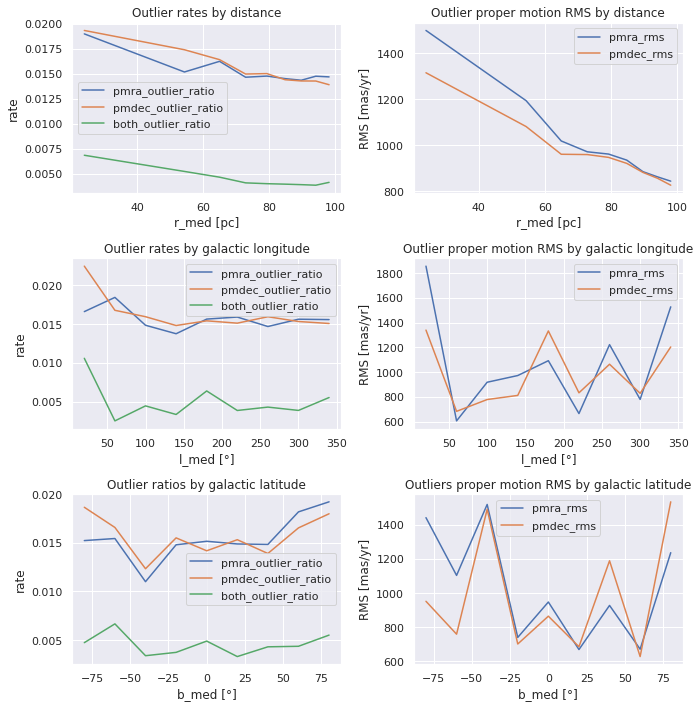

In [ ]:
plt.figure(figsize=(10,10))
ax= plt.subplot(3,2,1)
ax.set_title('Outlier rates by distance')
sns.lineplot(data= ratio_means,x='r_med', y='pmra_outlier_ratio', label='pmra_outlier_ratio', ax=ax)
sns.lineplot(data= ratio_means,x='r_med', y='pmdec_outlier_ratio', label='pmdec_outlier_ratio', ax=ax)
sns.lineplot(data= ratio_means,x='r_med', y='both_outlier_ratio', label='both_outlier_ratio', ax=ax)
ax.set_xlabel('r_med [pc]')
ax.set_ylabel('rate')


ax1=plt.subplot(3,2,2)
ax1.set_title('Outlier proper motion RMS by distance')
sns.lineplot(data= ratio_means,x='r_med', y='pmra_rms', label='pmra_rms',  ax=ax1)
sns.lineplot(data= ratio_means,x='r_med', y='pmdec_rms', label='pmdec_rms',  ax=ax1)
ax1.set_xlabel('r_med [pc]')
ax1.set_ylabel('RMS [mas/yr]')


ax2=plt.subplot(3,2,3)
ax2.set_title('Outlier rates by galactic longitude')
sns.lineplot(data= ratio_l_means,x='l_med', y='pmra_outlier_ratio', label='pmra_outlier_ratio', ax=ax2)
sns.lineplot(data= ratio_l_means,x='l_med', y='pmdec_outlier_ratio', label='pmdec_outlier_ratio', ax=ax2)
sns.lineplot(data= ratio_l_means,x='l_med', y='both_outlier_ratio', label='both_outlier_ratio', ax=ax2)
ax2.set_xlabel('l_med [°]')
ax2.set_ylabel('rate')

ax3=plt.subplot(3,2,4)
ax3.set_title('Outlier proper motion RMS by galactic longitude')
sns.lineplot(data= ratio_l_means,x='l_med', y='pmra_rms', label='pmra_rms', ax=ax3)
sns.lineplot(data= ratio_l_means,x='l_med', y='pmdec_rms', label='pmdec_rms', ax=ax3)
ax3.set_xlabel('l_med [°]')
ax3.set_ylabel('RMS [mas/yr]')


ax4=plt.subplot(3,2,5)
ax4.set_title('Outlier ratios by galactic latitude')
sns.lineplot(data= ratio_b_means,x='b_med', y='pmra_outlier_ratio', label='pmra_outlier_ratio', ax=ax4)
sns.lineplot(data= ratio_b_means,x='b_med', y='pmdec_outlier_ratio', label='pmdec_outlier_ratio', ax=ax4)
sns.lineplot(data= ratio_b_means,x='b_med', y='both_outlier_ratio', label='both_outlier_ratio', ax=ax4)
ax4.set_xlabel('b_med [°]')
ax4.set_ylabel('rate')

ax6=plt.subplot(3,2,6)
ax6.set_title('Outliers proper motion RMS by galactic latitude')
sns.lineplot(data= ratio_b_means,x='b_med', y='pmra_rms', label='pmra_rms', ax=ax6)
sns.lineplot(data= ratio_b_means,x='b_med', y='pmdec_rms', label='pmdec_rms', ax=ax6)
ax6.set_xlabel('b_med [°]')
ax6.set_ylabel('RMS [mas/yr]')


plt.legend()
plt.tight_layout()
plt.show()

## Densidad de estrellas

### pmra and pmdec outliers

In [ ]:
pmra_outliers= pd.concat([ cube.pmra_outliers for cube in cubes if len(cube.pmra_outliers)!=0],axis=0)
pmdec_outliers= pd.concat([ cube.pmdec_outliers for cube in cubes if len(cube.pmra_outliers)!=0],axis=0)

### both pmra and pmdec outliers

In [ ]:
common= pd.DataFrame(list(set(pmra_outliers.source_id) & set(pmdec_outliers.source_id)), columns=['source_id'])
both_outliers= pd.merge(common,results, on=['source_id'])

## Exporting files as csv

In [ ]:
cubos= pd.DataFrame({
    'r_med': [(cube.ri + cube.rf)/2 for cube in cubes],
    'l_med': [(cube.li + cube.lf)/2 for cube in cubes],
    'b_med': [(cube.bi + cube.bf)/2 for cube in cubes],
    'pmra': [ cube.avgpmra for cube in cubes],
    'pmdec': [ cube.avgpmdec for cube in cubes],
    'std_pmra': [cube.pmra_std for cube in cubes],
    'std_pmdec': [cube.pmdec_std for cube in cubes]
})

In [ ]:
#cubos
cubos.to_csv('cubos.csv')

#En pmra, pmdec
pmra_outliers.to_csv('pmra_outliers.csv')
pmdec_outliers.to_csv('pmdec_outliers.csv')

#En ambos
both_outliers.to_csv('both_outliers.csv')

## Heatmaps

In [ ]:
maps = [df_cubes.query(f'r_med=={dist}') for dist in df_cubes.r_med.unique()]

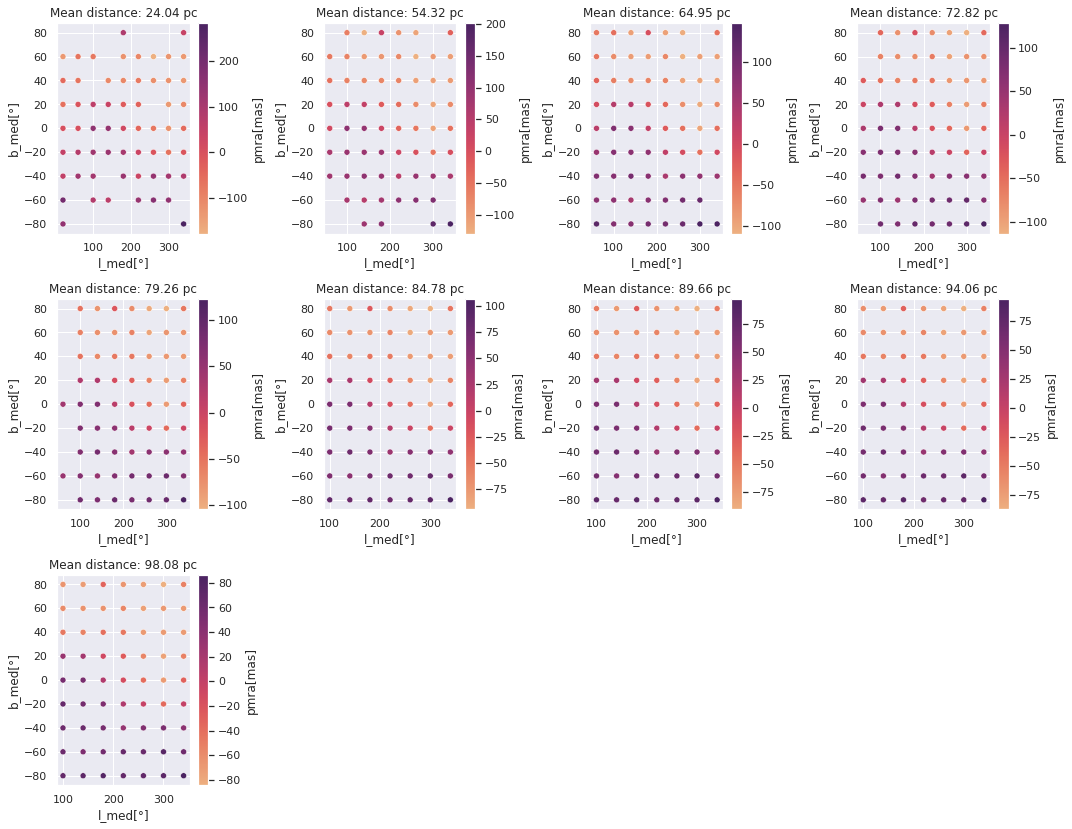

In [ ]:
plt.figure(figsize=(15,15))

for j,map in enumerate(maps):
  ax= plt.subplot(int(len(maps)/2),int(len(maps)/2), j+1)
  ax.set_title(f'Mean distance: {np.round(df_cubes.r_med.unique()[j],2)} pc')
  
  norm = plt.Normalize(map['pmra'].min(), map['pmra'].max())
  cb = plt.cm.ScalarMappable(cmap="flare", norm=norm)

  sns.scatterplot(data= map, x= 'l_med', y='b_med', hue='pmra', palette='flare')

  ax.legend().set_visible(False)
  ax.figure.colorbar(cb, label='pmra[mas]')
  ax.set_xlabel('l_med[°]')
  ax.set_ylabel('b_med[°]')

plt.tight_layout()
plt.show()

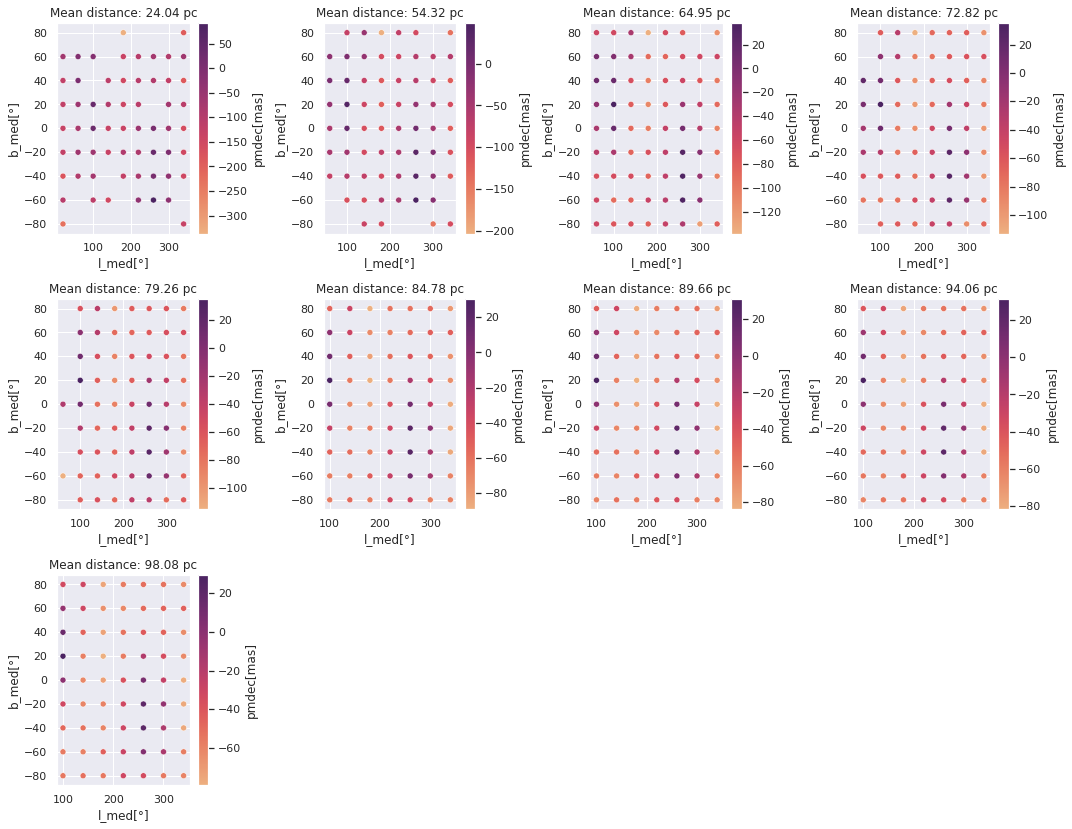

In [ ]:
plt.figure(figsize=(15,15))

for j,map in enumerate(maps):
  ax= plt.subplot(int(len(maps)/2),int(len(maps)/2), j+1)
  ax.set_title(f'Mean distance: {np.round(df_cubes.r_med.unique()[j],2)} pc')
  
  norm = plt.Normalize(map['pmdec'].min(), map['pmdec'].max())
  cb = plt.cm.ScalarMappable(cmap="flare", norm=norm)

  sns.scatterplot(data= map, x= 'l_med', y='b_med', hue='pmdec', palette='flare')

  ax.legend().set_visible(False)
  ax.figure.colorbar(cb, label='pmdec[mas]')
  ax.set_xlabel('l_med[°]')
  ax.set_ylabel('b_med[°]')

plt.tight_layout()
plt.show()